### Spectral Clustering - KNeighors Graph

In [1]:
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Read pitching pickle files

In [2]:
pitching = pd.read_pickle("./analysisdata/pitching.pkl")
pitchingSv = pitching
#pitchingScaled = pd.read_pickle("./analysisdata/pitchingScaled.pkl")

#print(pitching.info())
#print(pitchingScaled.info())

#### Data Preprocessing

##### ERA Outliers

In [3]:
print(pitching.ERA.describe())
pitching = pitching[pitching.ERA < 9]
pitching = pitching[pitching.yearID > 2007]

count    14473.000000
mean         5.028785
std          3.679510
min          0.000000
25%          3.390000
50%          4.310000
75%          5.570000
max        139.500000
Name: ERA, dtype: float64


##### Drop Unnecessary Columns and Scale Data

In [4]:
#Save pitcher IDs for potential post clustering analysis
pitchIDs = pitching[['yearID', 'playerID', 'salary', 'adjSalary2']]
#print(pitchIDs)

#One Hot Encoding for throws
tmp_df = pd.get_dummies(pitching.throws,prefix='throws')
pitchingSC = pd.concat((pitching,tmp_df),axis=1) # add back into the dataframe

#Drop Throws after one-hot encoding
#Drop Attributes no longer needed (MinSalaries, adjMinSalaries, adjSalary, playerID, bats, stint
pitchingSC = pitchingSC.drop(['height', 'weight', 'salary', 'MinSalaries', 'adjMinSalaries', 'adjSalary', 'adjSalary2', 'playerID', 'bats', 'stint', 'throws'], axis=1)
colNamesPSC = pitchingSC.columns

#Scale pitchingSC
scaler = StandardScaler()
pitchingSCScaled = scaler.fit_transform(pitchingSC)
pitchingSCScaled = pd.DataFrame(pitchingSCScaled, columns=colNamesPSC)

#print(pitchingSC.head())
#print(pitchingSC.info())
#print(pitchingSC.shape)
#print(pitchingSCScaled.head())
#print(pitchingSCScaled.info())


##### Create Value Based Arrays from Pitching Data Frames

In [5]:
#X = Unscaled values for Unscaled Data Frame
X = pitchingSC.iloc[:,0:30].values

#X2 for Scaled Data Frame
X2 = pitchingSCScaled.iloc[:,0:30].values

In [6]:
#print(X[:, 14])

##### Cluster Plotting Function

In [7]:
#Credit To:  https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

#### Train and Adjust Parameters

In [8]:
%%time

bestSil = 0
bestBigSil = 0

for nclust in range (2,6):
    for knn in range(5,26,5):
        Xknn = kneighbors_graph(X, knn)
        spcKNG = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
        labels = spcKNG.fit_predict(Xknn)
        silScore = metrics.silhouette_score(X, labels)
        #print(nclust, "Clusters", knn, "KN Graph", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))
        print(nclust, "Clusters", knn, "KN Graph", "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = nclust
            bestKnn = knn
        elif (nclust > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = nclust
                bestBigKnn = knn

2 Clusters 5 KN Graph Silhouette Coefficient: 0.7112
2 Clusters 10 KN Graph Silhouette Coefficient: 0.7123
2 Clusters 15 KN Graph Silhouette Coefficient: 0.7122
2 Clusters 20 KN Graph Silhouette Coefficient: 0.7118
2 Clusters 25 KN Graph Silhouette Coefficient: 0.7116
3 Clusters 5 KN Graph Silhouette Coefficient: 0.4950
3 Clusters 10 KN Graph Silhouette Coefficient: 0.5033
3 Clusters 15 KN Graph Silhouette Coefficient: 0.5015
3 Clusters 20 KN Graph Silhouette Coefficient: 0.5024
3 Clusters 25 KN Graph Silhouette Coefficient: 0.5018
4 Clusters 5 KN Graph Silhouette Coefficient: 0.4905
4 Clusters 10 KN Graph Silhouette Coefficient: 0.4873
4 Clusters 15 KN Graph Silhouette Coefficient: 0.4873
4 Clusters 20 KN Graph Silhouette Coefficient: 0.4846
4 Clusters 25 KN Graph Silhouette Coefficient: 0.4836
5 Clusters 5 KN Graph Silhouette Coefficient: 0.4582
5 Clusters 10 KN Graph Silhouette Coefficient: 0.4565
5 Clusters 15 KN Graph Silhouette Coefficient: 0.4563
5 Clusters 20 KN Graph Silhouett

#### Visualize Results

2 Clusters 10 KN Graph Silhouette Coefficient: 0.7123


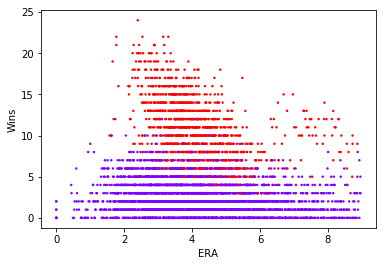

3 Clusters 10 KN Graph Silhouette Coefficient: 0.5033


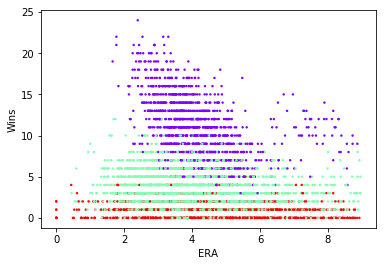

In [9]:
#print(spcKNG.affinity_matrix_)
#print(spcKNG.labels_)

#nclust = 2
#Best Spectral Cluster
Xknn = kneighbors_graph(X, bestKnn)

spcKNG = SpectralClustering(n_clusters=bestClust, affinity = 'precomputed')
labels = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labels, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestClust, "Clusters", bestKnn, "KN Graph", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.show()

#Best Spectral Cluster with > 2 Clusters
Xknn = kneighbors_graph(X, bestBigKnn)

spcKNG = SpectralClustering(n_clusters=bestBigClust, affinity = 'precomputed')
labels = spcKNG.fit_predict(Xknn)
#print(len(labels))

plt.scatter(X[:, 14], X[:, 0], c=labels, cmap=plt.cm.rainbow, s=6, linewidths=0)
print(bestBigClust, "Clusters", bestBigKnn, "KN Graph", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.show()

### Hierarchical Agglomerate Clustering
#### Train and Adjust Parameters

In [10]:
%%time 

bestSil = 0
bestBigSil = 0

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,6):
        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(pitchingSC)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, newfeature_fam)
        #print(n_fam, "Clusters", "Linkage:", link, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))
        print(n_fam, "Clusters", "Linkage:", link, "Silhouette Coefficient: %0.4f" % silScore)
        if (silScore > bestSil):
            bestSil = silScore
            bestClust = n_fam
            bestLink = link
        elif (n_fam > 2):
            if (silScore > bestBigSil):
                bestBigSil = silScore
                bestBigClust = n_fam
                bestBigLink = link        
                print(bestBigSil, bestBigClust, bestBigLink)

2 Clusters Linkage: ward Silhouette Coefficient: 0.7108
3 Clusters Linkage: ward Silhouette Coefficient: 0.5175
0.5174955460519973 3 ward
4 Clusters Linkage: ward Silhouette Coefficient: 0.5054
5 Clusters Linkage: ward Silhouette Coefficient: 0.4775
2 Clusters Linkage: complete Silhouette Coefficient: 0.7142
3 Clusters Linkage: complete Silhouette Coefficient: 0.5945
0.5944690909342981 3 complete
4 Clusters Linkage: complete Silhouette Coefficient: 0.5159
5 Clusters Linkage: complete Silhouette Coefficient: 0.4807
2 Clusters Linkage: average Silhouette Coefficient: 0.6742
3 Clusters Linkage: average Silhouette Coefficient: 0.5693
4 Clusters Linkage: average Silhouette Coefficient: 0.4435
5 Clusters Linkage: average Silhouette Coefficient: 0.4856
CPU times: user 20.9 s, sys: 3.32 s, total: 24.2 s
Wall time: 24.2 s


#### Visualize Results

2 Clusters Linkage: complete Silhouette Coefficient: 0.7142


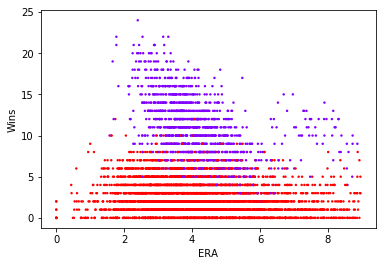

3 Clusters Linkage: complete Silhouette Coefficient: 0.5945


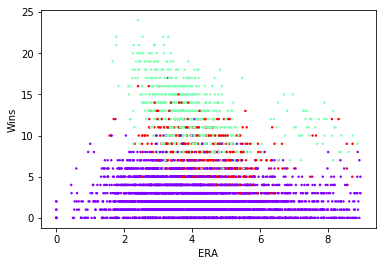

In [11]:
#Best HAC Model
cls_fam = AgglomerativeClustering(n_clusters=bestClust, linkage=bestLink)
cls_fam.fit(pitchingSC)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
print(bestClust, "Clusters", "Linkage:", bestLink, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_fam, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.show()

#Best HAC Model with > 2 Clusters
cls_fam = AgglomerativeClustering(n_clusters=bestBigClust, linkage=bestBigLink)
cls_fam.fit(pitchingSC)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
print(bestBigClust, "Clusters", "Linkage:", bestBigLink, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=newfeature_fam, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.show()

### HDBSCAN

#### Train and Adjust Parameters

In [12]:
%%time 

bestSil = 0

params = []
for mcs in range(10,60,10):
    for ms in range(1, 6, 1):
        cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        cls_hdbs.fit(pitchingSC)
        labelsHdbs = cls_hdbs.labels_ # the labels from kmeans clustering
        silScore = metrics.silhouette_score(pitchingSC, labelsHdbs)
        #print(n_fam, "Clusters", "Linkage:", link, "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, newfeature_fam))
        print(mcs, "Min Cluster Size", ms, "Min Samples", "Silhouette Coefficient: %0.4f" % silScore)
        if (np.absolute(silScore) > bestSil):
            bestSil = np.absolute(silScore)
            bestMCS = mcs
            bestMS = ms

10 Min Cluster Size 1 Min Samples Silhouette Coefficient: -0.3015
10 Min Cluster Size 2 Min Samples Silhouette Coefficient: 0.2718
10 Min Cluster Size 3 Min Samples Silhouette Coefficient: 0.3000
10 Min Cluster Size 4 Min Samples Silhouette Coefficient: 0.3019
10 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.2533
20 Min Cluster Size 1 Min Samples Silhouette Coefficient: 0.3145
20 Min Cluster Size 2 Min Samples Silhouette Coefficient: 0.3438
20 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.4195
20 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.3198
20 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.3169
30 Min Cluster Size 1 Min Samples Silhouette Coefficient: 0.3949
30 Min Cluster Size 2 Min Samples Silhouette Coefficient: 0.3675
30 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.3155
30 Min Cluster Size 4 Min Samples Silhouette Coefficient: -0.2169
30 Min Cluster Size 5 Min Samples Silhouette Coefficient: -0.2990
40 Min Cluster Si

#### Visualize Results

20 Min Cluster Size 3 Min Samples Silhouette Coefficient: -0.4195


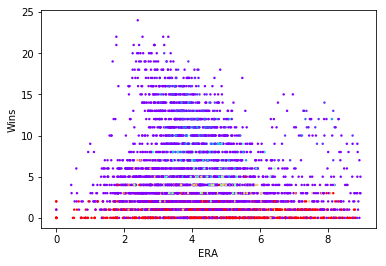

In [13]:
#Best HAC Model
cls_hdbs = hdbscan.HDBSCAN(min_cluster_size=bestMCS, min_samples=bestMS)
cls_hdbs.fit(pitchingSC)
labelsHdbs = cls_hdbs.labels_ 
print(bestMCS, "Min Cluster Size", bestMS, "Min Samples", "Silhouette Coefficient: %0.4f" % metrics.silhouette_score(pitchingSC, labelsHdbs))

plt.scatter(pitchingSC.ERA, pitchingSC.W, c=labelsHdbs, cmap=plt.cm.rainbow, s=6, linewidths=0)
plt.xlabel('ERA')
plt.ylabel('Wins')
plt.show()